In [2]:
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(tibble)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(viridis)
library(pheatmap)

[1] ‘3.4.2’


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



[1] ‘2.6.4’

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
tab_dir <- '~/data/awtp2/metagenomics/tables/'
figs_dir <- '~/data/awtp2/metagenomics/figures/'

In [42]:
# #adding sample names and resaving the file

# metadata <- read.table('~/data/awtp2_metagenomics/metagenome_info_tables/metagenomics_sample_table.tsv', sep='\t', header = TRUE)
# metadata <- metadata[metadata$project_type == 'DPWF',]

# metadata$location_gen <- metadata$location_code
# # condense down to simple general location
# metadata[metadata$location_code %in% c("MF_tank", "MF_combined"),]$location_gen <- "MF"
# metadata[metadata$location_code %in% c("RO", "RO_combined", "RO_3stage", "RO_2stage"),]$location_gen <- "RO"
# metadata[metadata$location_code %in% c("RO_BF_separator"),]$location_gen <- "RO_BF_sep"
# metadata[metadata$location_code %in% c("RO_BF_retentate_scrapings"),]$location_gen <- "RO_BF_ret"

# # construct new names from other columns (matching 16S names)
# metadata$sample_date <- as.Date(metadata$sample_date, format = "%m/%d/%Y")
# day0 <- as.Date("2017-9-14") # This is the first day of sampling
# metadata$sample_day <- as.numeric(metadata$sample_date - day0)
# metadata$sample_name <- stringr::str_c(metadata$location_gen, "_", metadata$sample_day)

# write.table(metadata, '~/data/awtp2_metagenomics/metagenome_info_tables/metagenomics_sample_table_awtp2.tsv', sep='\t', row.names=FALSE)

In [ ]:
# # set levels for plotting

# # renaming things

# metadata$location_gen <- metadata$location_code
                                            
# new_levels <- c('WW_3ary',
# 'BAC',
# 'MF_combined',
# 'MF_tank',
# 'MF',
# 'RO_BF_retentate_scrapings',
# 'RO_BF_separator',
# 'RO_combined',
# 'RO_3stage',
# 'RO_2stage',
# 'RO')


# # sort samples and make factor so they will plot in order
# name_levels <- sample_data(ps_awtp)[order(sample_data(ps_awtp)$location_code, sample_data(ps_awtp)$sample_date)]$sample_name
# sample_data(ps_awtp)$sample_name <- factor(sample_data(ps_awtp)$sample_name, levels=name_levels)

# MASH distances with reads

In [9]:
dist <- read.table(paste0(tab_dir, 'awtp2_mash_dist.txt'), sep='\t',
                   col.names = c('query', 'ref', 'distance', 'pval', 'matching_hashes'))

dist$distance <- as.numeric(dist$distance)

metadata <- read.table('~/data/awtp2/metagenomics/tables/metagenomics_sample_table_awtp2.tsv', sep='\t', header = TRUE)
# get a lookup of sample_id to sample_code:

id2code <- metadata[,c('sample_id', 'sample_name')]

head(dist)
head(id2code)

,query,ref,distance,pval,matching_hashes
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,KNLK_11,KNLK_11,0.0000000,0.00000e+00,10000/10000
2,KNLK_13,KNLK_11,0.1912090,8.01352e-143,91/10000
3,KNLK_16,KNLK_11,0.1447690,0.00000e+00,245/10000
4,KNLK_23,KNLK_11,0.1938770,9.28982e-137,86/10000
5,KNLK_28,KNLK_11,0.1528430,0.00000e+00,206/10000
6,KNLK_32,KNLK_11,0.0371254,0.00000e+00,2975/10000


,sample_id,sample_name
,<chr>,<chr>
1,KNLK_11,BAC_91
2,KNLK_13,RO_BF_sep_328
3,KNLK_16,MF_26
4,KNLK_23,RO_61
5,KNLK_28,MF_61
6,KNLK_32,BAC_26


In [10]:
# get sample names for plotting
df <- merge(dist, id2code, by.x='query', by.y='sample_id')
df <- merge(df, id2code, by.x='ref', by.y='sample_id')
df <- df[order(df$sample_name.x, df$sample_name.y),] # sort df

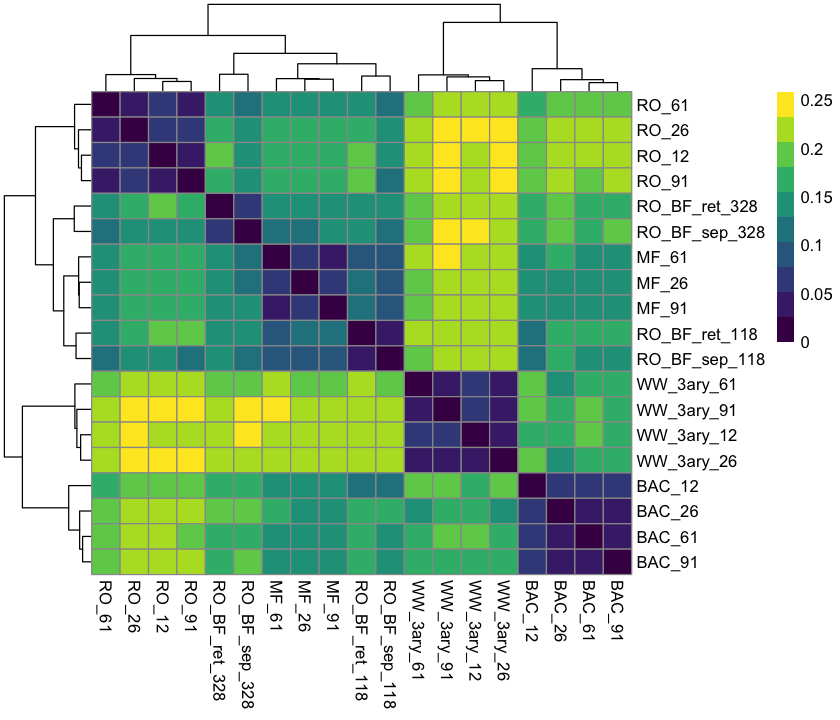

In [11]:
#subset selected columns
df2 <- df[c('sample_name.x', 'sample_name.y', 'distance')]
#reformat table to wide
df_wide <- df2 %>% spread(sample_name.y, distance) %>% column_to_rownames('sample_name.x')
#heatplus requires a matrix not a dataframe
m <- as.matrix(df_wide)
options(repr.plot.width = 7, repr.plot.height = 6)
pheatmap(m, color=viridis(10))
# pheatmap(m, color=viridis(10), filename=paste0(figs_dir, 'mash_dist_clustered_heatmap.pdf'))
# pheatmap(m, color=viridis(10), filename=paste0(figs_dir, 'mash_dist_clustered_heatmap.png'))

# Compile summary table

## Read and process all tables

In [179]:
# non-sequencing data
nonseqdata <- read.table(paste0(tab_dir, 'metagenomics_sample_table.tsv'), sep='\t', header = TRUE)
awtp2_nonseqdata <- nonseqdata[nonseqdata$project_type=='DPWF',]
awtp2_nonseqdata <- rename(awtp2_nonseqdata, sample_name=sample_code_partial)
awtp2_nonseqdata <- subset(awtp2_nonseqdata, select=c('sample_id', 'DNA_Ext_conc_ng.uL', 'sample_date', 'location_code', 'sample_name'))

,sample_id,DNA_Ext_conc_ng.uL,sample_date,location_code,sample_name
,<fct>,<dbl>,<fct>,<fct>,<fct>
3,KNLK_11,169.000,12/14/2017,BAC,AWTP_2_BAC_bulk_5
5,KNLK_13,0.071,8/8/2018,RO_BF_separator,AWTP_2_RO2_biofilm_sep_2
8,KNLK_16,1.070,10/10/2017,MF_combined,AWTP_2_MF_comb_bulk_1
16,KNLK_23,0.399,11/14/2017,RO_2stage,AWTP_2_RO2_bulk_5
21,KNLK_28,1.910,11/14/2017,MF_combined,AWTP_2_MF_comb_bulk_2
26,KNLK_32,27.000,10/10/2017,BAC,AWTP_2_BAC_bulk_3
27,KNLK_33,518.000,11/14/2017,WW_3ary,AWTP_2_inf_bulk_4
32,KNLK_38,1.170,1/10/2018,RO_BF_separator,AWTP_2_RO2_biofilm_sep_1
38,KNLK_43,30.500,8/8/2018,RO_BF_retentate_scrapings,AWTP_2_RO2_biofilm_ret_scrape_2


In [168]:
# trimmed read data
reads <- read.table(paste0(tab_dir, 'trimmed_reads_stats.txt'), sep='\t', header=TRUE)
reads = separate(reads, col=file, into=c('sample_id', 'mate_pair'), sep='\\.', extra='merge')
reads = reads[c(1,2,5,6)] %>% group_by(sample_id) %>% summarise_if(is.numeric, sum)
colnames(reads) <- c('sample_id', 'read_count', 'length_reads')
reads$read_count_M <- round((reads$read_count / 1e6),1)
reads$length_reads_Gbp <- round((reads$length_reads / 1e9),1)
reads <- reads[c('sample_id', 'read_count', 'read_count_M', 'length_reads_Gbp')]

In [169]:
# megahit assembly data
assemblies <- read.table(paste0(tab_dir, 'assembly_stats.megahit.042720.txt'), sep=' ', header=FALSE)
assemblies <- assemblies[c(1,4,7,13,16,19)]
colnames(assemblies) <- c('name', 'num_contigs', 'length_assem_bp', 'length_max_contig', 'length_avg_contig', 'assem_N50')
assemblies <- separate(assemblies, col=name, into=c('sample_name'), sep='/', extra='drop')
assemblies$length_assem_Mbp <- round((assemblies$length_assem_bp / 1e6),1)
assemblies <- subset(assemblies, select=-c(length_assem_bp))

In [201]:
# contamination data
contam <- read.table(paste0(tab_dir, 'all_contam_report.txt'), sep='\t', header=TRUE)
colnames(contam) <- c('sample_name',
                       'contams_perc_of_total_cov', 
                       'contams_perc_of_total_length',
                       'contams_length_bp',
                       'length_assem_min1000',
                       'contams_num_splits')

In [170]:
# readmapping data
reads_mapped <- read.table(paste0(tab_dir, 'reads_mapped_DPWF.txt'), header=FALSE)
colnames(reads_mapped) <- c('reads_mapped')
count_cmd <- read.table('~/work/awtp2/workflows/count_mapped_DPWF.sh', sep=' ', header=FALSE)[6]
colnames(count_cmd) <- c('mapping')
sample_id <- extract(count_cmd, col=mapping, into='sample_id', regex=".+-vs-(.+).bam", remove=TRUE)
reads_mapped <- cbind(sample_id, reads_mapped)

In [171]:
# anvio assembly info
# update this after spliting out contams
contig_stats <- t(read.table(paste0(tab_dir, 'contig_stats_includesContams.txt'), header=TRUE, row.names=1, sep='\t'))
contig_stats <- as.data.frame(contig_stats)
contig_stats <- contig_stats[order(row.names(contig_stats)),]
contig_stats <- subset(contig_stats, select=c('Num Contigs', 'Ribosomal_RNAs', 'bacteria (Bacteria_71)', 'archaea (Archaea_76)', 'eukarya (Protista_83)'))
contig_stats <- rownames_to_column(contig_stats, var = "sample_name")
colnames(contig_stats) <- c('sample_name', 'num_contigs_min1000', 'rRNA_genes', 'est_num_bacteria', 'est_num_archaea', 'est_num_protista')

## Merge tables and make plots

In [240]:
merged_data <- merge(awtp2_nonseqdata, reads, by='sample_id')
merged_data <- merge(merged_data, assemblies, by='sample_name')
merged_data <- merge(merged_data, reads_mapped, by='sample_id')
merged_data <- merge(merged_data, contam, by='sample_name')
merged_data <- merge(merged_data, contig_stats, by='sample_name')
merged_data$location_code <- factor(merged_data$location_code, levels = c('WW_3ary', 'BAC', 'MF_combined', 'RO_2stage', 'RO_BF_retentate_scrapings', 'RO_BF_separator'))
merged_data$perc_mapped <- round(100*(merged_data$reads_mapped / merged_data$read_count),2)
merged_data$sample_date <- as.Date(merged_data$sample_date, '%m/%d/%Y')
merged_data <- merged_data[order(merged_data$location_code, merged_data$sample_date), ]
merged_data

,sample_name,sample_id,DNA_Ext_conc_ng.uL,sample_date,location_code,read_count,read_count_M,length_reads_Gbp,num_contigs,length_max_contig,⋯,contams_perc_of_total_length,contams_length_bp,length_assem_min1000,contams_num_splits,num_contigs_min1000,rRNA_genes,est_num_bacteria,est_num_archaea,est_num_protista,perc_mapped
,<fct>,<fct>,<dbl>,<date>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
5,AWTP_2_inf_bulk_2,KNLK_77,158.000,2017-09-26,WW_3ary,197255244,197.3,29.4,507170,760303,⋯,0.00,2555,270750259,2,81082,120,57,1,1,88.02
6,AWTP_2_inf_bulk_3,KNLK_66,680.000,2017-10-10,WW_3ary,191306438,191.3,28.6,473614,1360333,⋯,0.00,11564,314334042,8,86068,156,101,0,0,89.65
7,AWTP_2_inf_bulk_4,KNLK_33,518.000,2017-11-14,WW_3ary,183699926,183.7,27.5,449254,1014114,⋯,0.01,17084,270473050,12,75409,117,76,0,0,88.29
8,AWTP_2_inf_bulk_5,KNLK_44,542.000,2017-12-14,WW_3ary,105419942,105.4,15.8,347968,869440,⋯,0.00,5363,229061380,4,66387,90,51,1,0,87.81
1,AWTP_2_BAC_bulk_2,KNLK_9,17.500,2017-09-26,BAC,196383818,196.4,29.4,1522973,1345282,⋯,0.38,3227142,848943691,1840,280549,254,171,0,0,77.71
2,AWTP_2_BAC_bulk_3,KNLK_32,27.000,2017-10-10,BAC,158516508,158.5,23.7,993532,1532752,⋯,0.01,75160,693959676,23,185429,235,129,0,0,80.85
3,AWTP_2_BAC_bulk_4,KNLK_76,85.600,2017-11-14,BAC,201743132,201.7,30.0,1478460,1389257,⋯,0.01,104544,903530568,38,274462,304,221,1,0,76.47
4,AWTP_2_BAC_bulk_5,KNLK_11,169.000,2017-12-14,BAC,192964882,193.0,28.7,1197560,1055407,⋯,0.01,65315,768631524,29,204165,273,195,0,0,80.02
9,AWTP_2_MF_comb_bulk_1,KNLK_16,1.070,2017-10-10,MF_combined,47973524,48.0,7.2,223492,822776,⋯,2.77,3129092,112915796,1819,33185,48,29,0,0,85.50


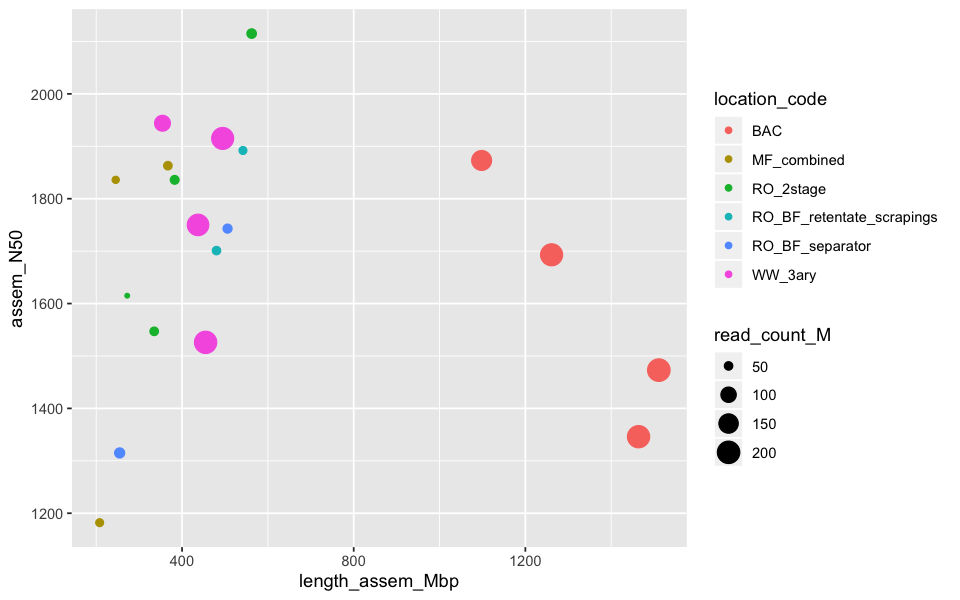

In [181]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(merged_data, aes(x=length_assem_Mbp, y=assem_N50, size=read_count_M, color=location_code))+
    geom_point()#+
    #scale_y_continuous(trans="log10", limits=c(1e8, 1e10), labels=trans_format("log10", math_format(10^.x)))

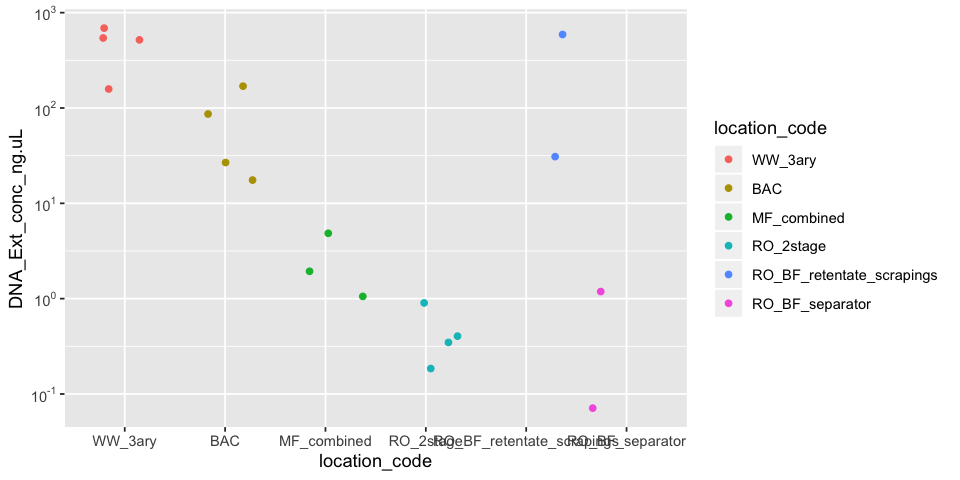

In [203]:
options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(merged_data, aes(x=location_code, y=DNA_Ext_conc_ng.uL, color=location_code))+
    geom_jitter()+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

Warning message:
“Transformation introduced infinite values in continuous y-axis”

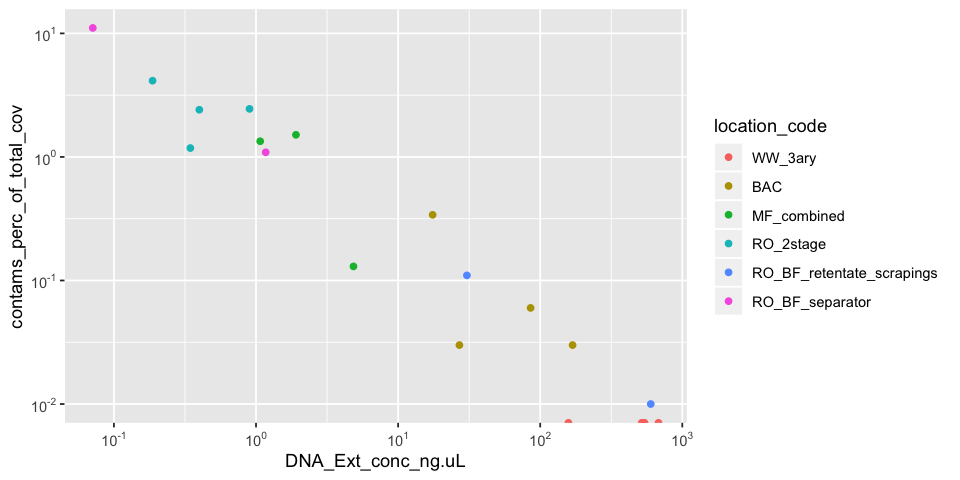

In [227]:
options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(merged_data, aes(x=DNA_Ext_conc_ng.uL, y = contams_perc_of_total_cov, color=location_code))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

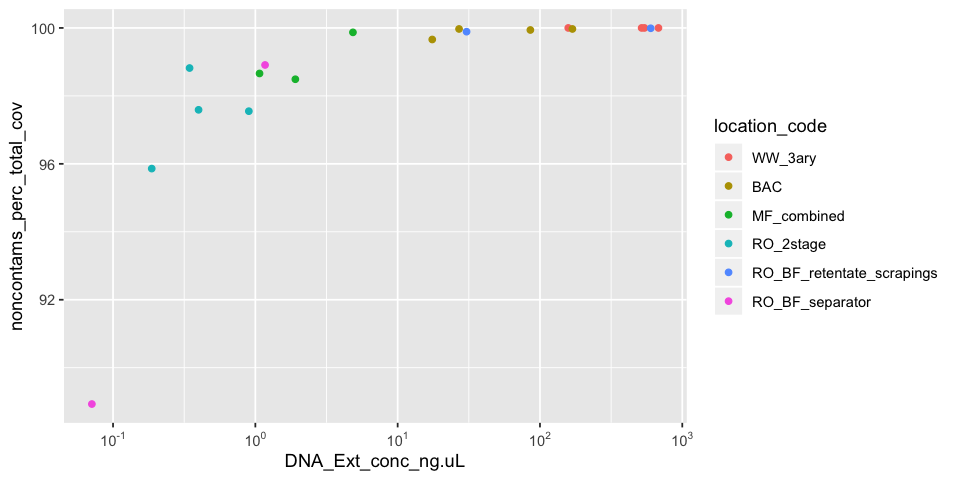

In [248]:
merged_data$noncontams_perc_total_cov <- 100-merged_data$contams_perc_of_total_cov

options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(merged_data, aes(x=DNA_Ext_conc_ng.uL, y = noncontams_perc_total_cov, color=location_code))+
    geom_point()+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))
    #scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

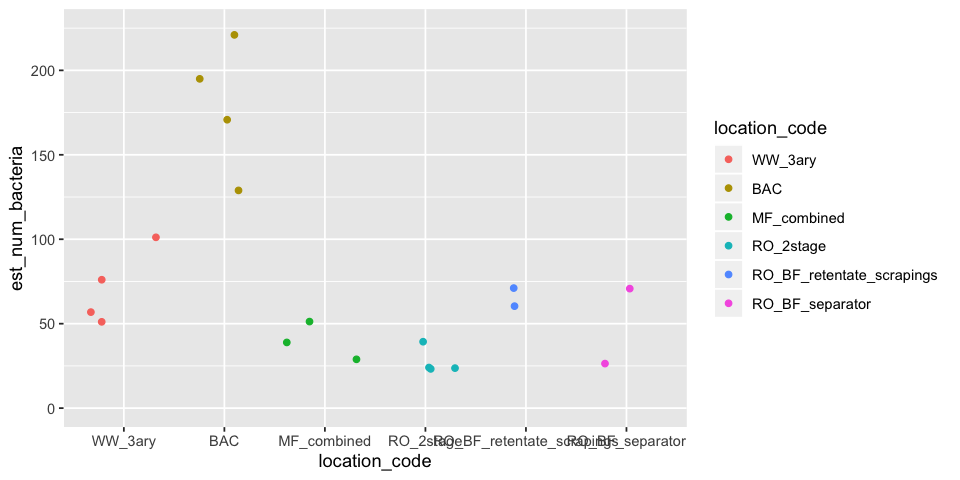

In [256]:
ggplot(merged_data, aes(x=location_code, y=est_num_bacteria, color=location_code))+
    geom_jitter()+
    ylim(0,225)

# MAGs relative abundance

In [3]:
mag_data = '/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_FiltNormCov_for_plotting.tsv'
mags_df <- read.table(mag_data, sep='\t', header=TRUE) # add length and GC info

#subset selected columns
mags_df <- mags_df[c('sample_id', 'sensible_name', 'rpkm')] #'normalized_cov'

#reformat table to wide
mags_df <- mags_df %>% 
                    pivot_wider(id_cols='sample_id', names_from='sensible_name', values_from='rpkm') %>% #'normalized_cov'
                    column_to_rownames('sample_id')

In [4]:
#get prefered ordering of samples by creating a column called Row.names, ordering by it, and then dropping it
sample_order = c('WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
                'BAC_12','BAC_26','BAC_61','BAC_91',
                'MF_combined_26','MF_combined_61','MF_combined_91',
                'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91')


mags_df$Row.names <- row.names(mags_df)
mags_df$Row.names <- factor(mags_df$Row.names, levels=sample_order)
mags_df <- mags_df[order(mags_df$Row.names),]
row.names(mags_df) <- mags_df$Row.names 
mags_df <- subset(mags_df, select=-c(Row.names))

## All membrane dRep MAGs

In [5]:
#clustering samples and MAGs for clustered heatmap (make sure NAs are zeros)

#cluster samples by bray curtis (first turn NA to zero)
mags_for_clust <- mags_df
mags_for_clust[is.na(mags_for_clust)] <- 0

#somehow this is clustering the samples, not the mags...

#cluster MAGs by occurrence, using Spearman rank correlation converted to distance matrix
corrdist_dissimilarity <- as.dist(1 - cor(mags_for_clust, method="spearman")) 
mag_clust <- hclust(corrdist_dissimilarity)

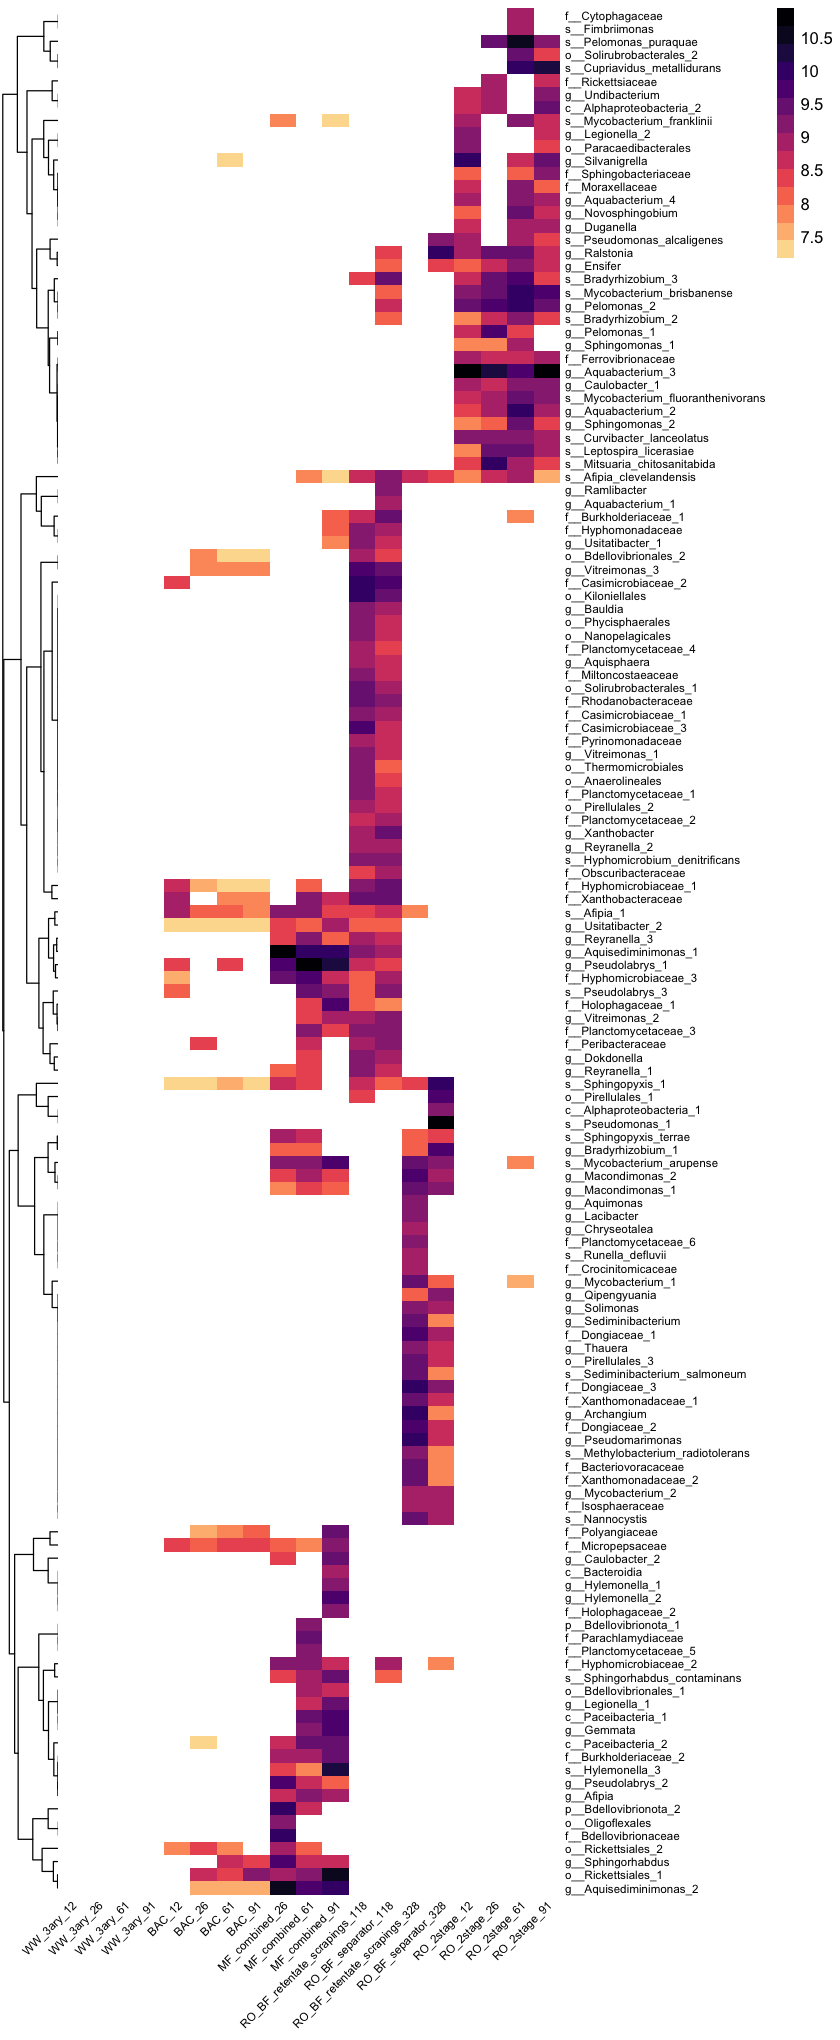

In [6]:
#heatplus requires a matrix not a dataframe
mags_df <- as.matrix(mags_df)


#Log-scale and plot heatmaps
#rps3_norm <- ifelse(rps3_norm==0, NA, rps3_norm) #make sure zeros are NAs for non-detects
mags.logabundance <- log10(mags_df)

options(repr.plot.width = 7, repr.plot.height = 17)

pheatmap(t(mags.logabundance), 
         color=rev(magma(15)[1:14]), 
         #cluster_cols=sample_clust, 
         cluster_cols=FALSE,
         cluster_rows=mag_clust,
         na_col="white",
         border_color='black',
         #labels_row=as.character(genera$tax),
         #labels_col=as.character(metagenome_info$Sample_code), #to change col names
         fontsize_row=7, fontsize_col=7,
         treeheight_row=30,
         angle_col=45,
         width=7, height=15
        #, filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.png"
        #,filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.pdf"
)
     


## filter to keep only MAGs that were present in RO perm samples

In [111]:
# mags_df %>% filter()
# these MAGs have nitrogen fixation:
as.data.frame(mags_df) %>% select(s__Bradyrhizobium_3,g__Macondimonas_1,g__Aquabacterium_3,g__Aquabacterium_2,s__Curvibacter_lanceolatus)

,s__Bradyrhizobium_3,g__Macondimonas_1,g__Aquabacterium_3,g__Aquabacterium_2,s__Curvibacter_lanceolatus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WW_3ary_12,NA,NA,NA,NA,NA
WW_3ary_26,NA,NA,NA,NA,NA
WW_3ary_61,NA,NA,NA,NA,NA
WW_3ary_91,NA,NA,NA,NA,NA
BAC_12,NA,NA,NA,NA,NA
BAC_26,NA,NA,NA,NA,NA
BAC_61,NA,NA,NA,NA,NA
BAC_91,NA,NA,NA,NA,NA
MF_combined_26,NA,0.5209082,NA,NA,NA


## average the coverages and plot rank abundance curves for MF and RO

In [113]:
mags_df <- as.data.frame(mags_df)

In [118]:
mags_RO_df <- mags_df %>% filter(row.names(mags_df) %in% c('RO_2stage_12', 'RO_2stage_26', 'RO_2stage_61', 'RO_2stage_91')) #%>% drop_na()
mags_MF_df <- mags_df %>% filter(row.names(mags_df) %in% c('MF_combined_26', 'MF_combined_61', 'MF_combined_91'))  #%>% drop_na()

In [119]:
colMeans(mags_RO_df)

o__Oligoflexales                  o__Rickettsiales_2 
                                NaN                                 NaN 
              f__Bdellovibrionaceae               p__Bdellovibrionota_2 
                                NaN                                 NaN 
             s__Sphingopyxis_terrae                   g__Pseudolabrys_1 
                                NaN                                 NaN 
                  g__Sphingorhabdus                   g__Pseudolabrys_2 
                                NaN                                 NaN 
             f__Hyphomicrobiaceae_3                  c__Paceibacteria_1 
                                NaN                                 NaN 
             f__Hyphomicrobiaceae_2              o__Bdellovibrionales_1 
                                NaN                                 NaN 
               f__Parachlamydiaceae              f__Planctomycetaceae_5 
                                NaN                                 NaN 
                        s__Afipia_1                  c__Paceibacteria_2 
                                NaN                                 NaN 
                          g__Afipia                     g__Reyranella_3 
                                NaN                                 NaN 
              p__Bdellovibrionota_1                          g__Gemmata 
                                NaN                                 NaN 
                   f__Polyangiaceae                    g__Hylemonella_2 
                                NaN                                 NaN 
                  f__Micropepsaceae                  f__Holophagaceae_2 
                                NaN                                 NaN 
                 f__Holophagaceae_1               f__Burkholderiaceae_2 
                                NaN                                 NaN 
                   s__Hylemonella_3              g__Aquisediminimonas_1 
                                NaN                                 NaN 
      s__Sphingorhabdus_contaminans                    g__Hylemonella_1 
                                NaN                                 NaN 
                  s__Pseudolabrys_3                      c__Bacteroidia 
                                NaN                                 NaN 
                   g__Caulobacter_2                  g__Usitatibacter_2 
                                NaN                                 NaN 
                 o__Rickettsiales_1              g__Aquisediminimonas_2 
                                NaN                                 NaN 
                    g__Legionella_1                  f__Hyphomonadaceae 
                                NaN                                 NaN 
             f__Planctomycetaceae_1                   o__Pirellulales_2 
                                NaN                                 NaN 
                  o__Anaerolineales                o__Thermomicrobiales 
                                NaN                                 NaN 
                   g__Vitreimonas_1              f__Hyphomicrobiaceae_1 
                                NaN                                 NaN 
                      g__Dokdonella                 f__Pyrinomonadaceae 
                                NaN                                 NaN 
              f__Casimicrobiaceae_3              o__Bdellovibrionales_2 
                                NaN                                 NaN 
              f__Casimicrobiaceae_1                  g__Usitatibacter_1 
                                NaN                                 NaN 
                    g__Reyranella_1               f__Rhodanobacteraceae 
                                NaN                                 NaN 
               f__Xanthobacteraceae            o__Solirubrobacterales_1 
                                NaN                                 NaN 
               f__Miltoncostaeaceae                      g__Aquisphaera 
    

In [ ]:
#choose how many otus from top abundance to use (e.g. top 25 organisms in each sample)
num_rank <- 10
#melt together into 3 columns: genome, sample, abundance
meta.abundance2 <- as.data.frame(t(meta.alldatnorm))
meta.abundance2$bin <- row.names(meta.abundance2)
melted <- melt(meta.abundance2, id.vars = c("bin"), variable="Sample", value.name="Abundance")
melted$Abundance <- as.numeric(melted$Abundance)
head(melted)
#sort by sample (ascending), then by abundance (descending)
ordered <- melted[order(rev(melted$Abundance, decreasing = TRUE), ]
   
#add a column that is numerical ordering of 1...144 organisms and repeats for each sample
bins_count_vector <- 1:length(meta.abundance2$bin)
samples_count <- length(colnames(meta.abundance2))-1
Ranks <- rep(bins_count_vector, samples_count)

In [ ]:
ranked <- cbind(ordered, Ranks)
top_ranked <- subset(ranked, ranked$Ranks <= num_rank)
#top_ranked <- subset(topranked, topranked$Abundance>0)                     

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)

ggplot(top_ranked, aes(x=Ranks, y=Abundance)) + 
  geom_line() +
  geom_point(aes(color=bin), size=5) +
  ylab("Coverage per 10 million reads") +
  expand_limits(x = c(0,15), y = c(0,200)) +
  geom_text(aes(label=bin, vjust = -1, hjust = -.1), size = 3.5,  angle = 45) +
  theme(panel.background = element_blank(), axis.line = element_line(color = "black"), panel.grid.minor = element_blank(), panel.border = element_rect(color = "black", fill = NA), strip.background = element_blank()) +
  theme(legend.position="none") +
  facet_wrap(~ Sample, ncol=3)


# clustered heatmap of iRep

In [37]:
instrain_data = '/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/instrain/instrain_data_combined.tsv'
instrain_df <- read.table(instrain_data, sep='\t', header=TRUE)
#subset selected columns
instrain_df <- instrain_df[c('sample_id', 'sensible_name', 'iRep')]

#reformat table to wide
instrain_df <- instrain_df %>% 
                    #drop_na() %>%
                    pivot_wider(id_cols='sample_id', names_from='sensible_name', values_from='iRep') %>%
                    column_to_rownames('sample_id')

In [38]:
#get prefered ordering of samples by creating a column called Row.names, ordering by it, and then dropping it
sample_order = c('MF_combined_26','MF_combined_61','MF_combined_91',
                'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91')

In [39]:
instrain_df$Row.names <- row.names(instrain_df)
instrain_df$Row.names <- factor(instrain_df$Row.names, levels=sample_order)
instrain_df <- instrain_df[order(instrain_df$Row.names),]
row.names(instrain_df) <- instrain_df$Row.names 
instrain_df <- subset(instrain_df, select=-c(Row.names))

In [40]:
instrain_df

,s__Sphingopyxis_terrae,f__Isosphaeraceae,s__Nannocystis,g__Mycobacterium_2,f__Xanthomonadaceae_2,f__Bacteriovoracaceae,s__Methylobacterium_radiotolerans,g__Pseudomarimonas,f__Dongiaceae_2,f__Xanthomonadaceae_1,⋯,g__Ramlibacter,g__Aquabacterium_1,f__Cytophagaceae,s__Fimbriimonas,g__Sphingomonas_1,f__Polyangiaceae,g__Hylemonella_2,f__Holophagaceae_2,g__Hylemonella_1,c__Bacteroidia
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MF_combined_26,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MF_combined_61,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MF_combined_91,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,1.230322,1.252375,1.355724,1.307621,NA
RO_BF_retentate_scrapings_118,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RO_BF_separator_118,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,1.423923,1.398353,NA,NA,NA,NA,NA,NA,NA,NA
RO_BF_retentate_scrapings_328,NA,NA,1.485454,1.394487,1.503676,1.29488,1.422267,1.60845,1.234529,1.477534,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RO_BF_separator_328,NA,NA,2.096900,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RO_2stage_12,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
RO_2stage_26,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [23]:
# #clustering samples and MAGs for clustered heatmap (make sure NAs are zeros)

# #cluster samples by bray curtis (first turn NA to zero)
# mags_for_clust <- instrain_df
# mags_for_clust[is.na(mags_for_clust)] <- 0

# #somehow this is clustering the samples, not the mags...

# #cluster MAGs by occurrence, using Spearman rank correlation converted to distance matrix
# # corrdist_dissimilarity <- as.dist(1 - cor(mags_for_clust, method="spearman")) 
# # mag_clust <- hclust(corrdist_dissimilarity)

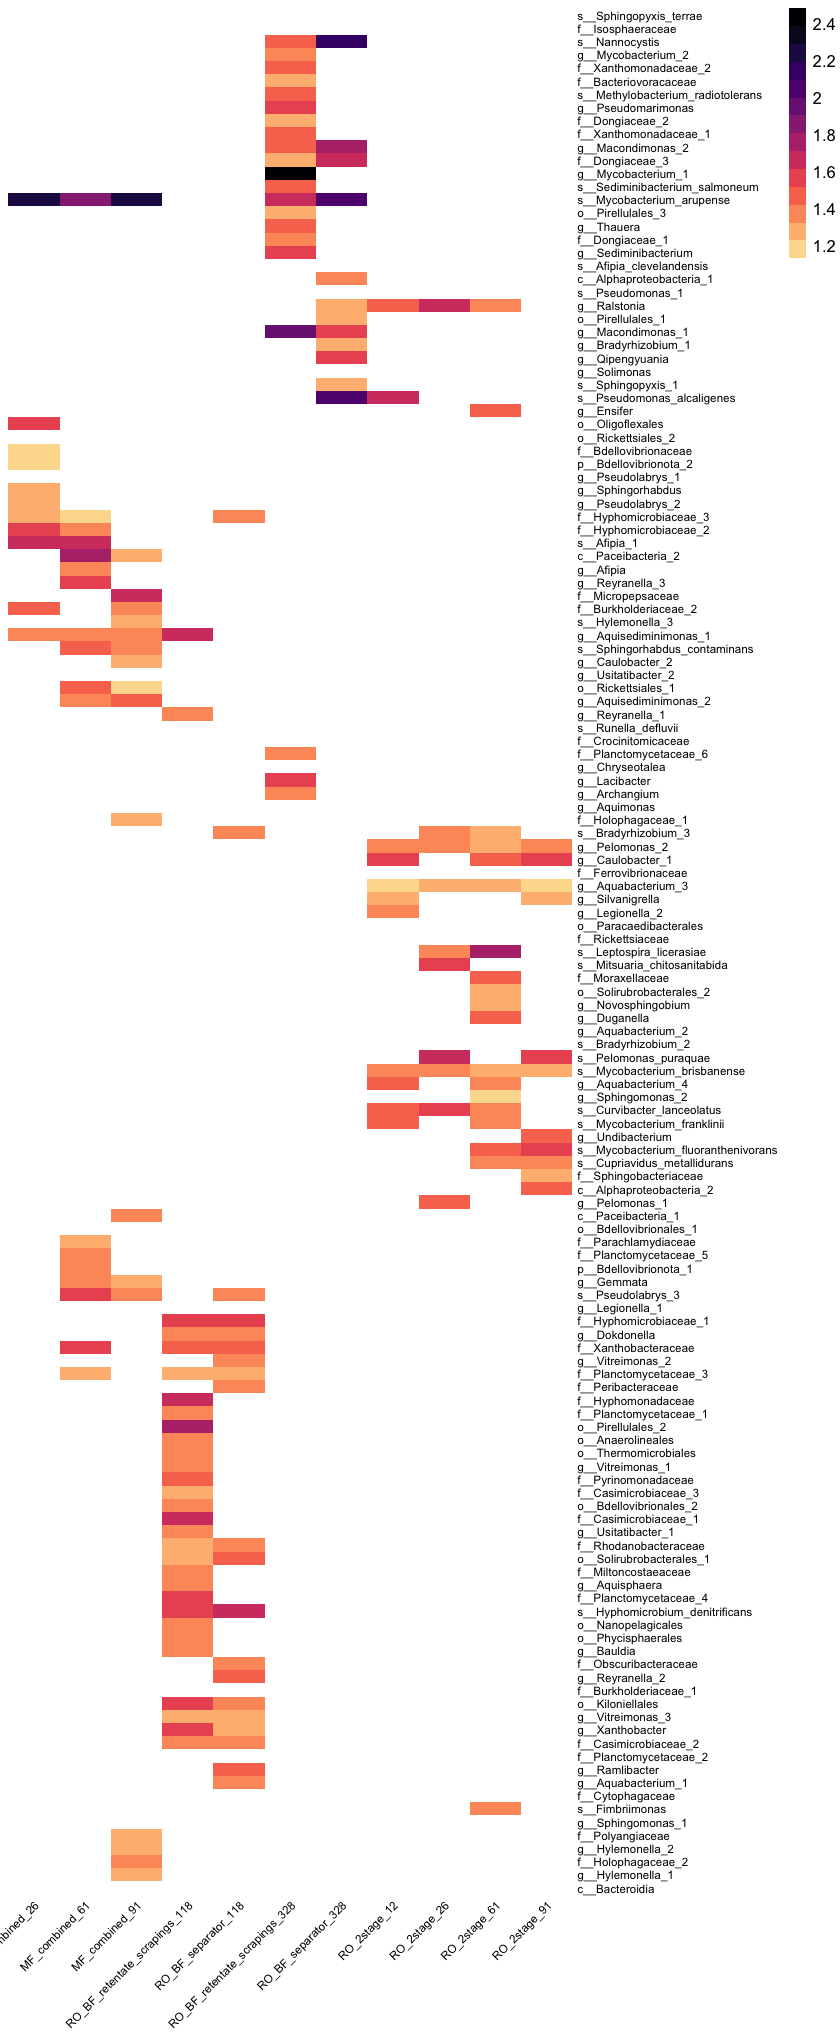

In [45]:
#heatplus requires a matrix not a dataframe
instrain_df <- as.matrix(instrain_df)

options(repr.plot.width = 7, repr.plot.height = 17)

pheatmap(t(instrain_df), 
         color=rev(magma(15)[1:14]), 
         #cluster_cols=sample_clust, 
         cluster_cols=FALSE,
         cluster_rows=FALSE,
         #cluster_rows=mag_clust,
         na_col="white",
         border_color='black',
         #labels_row=as.character(genera$tax),
         #labels_col=as.character(metagenome_info$Sample_code), #to change col names
         fontsize_row=7, fontsize_col=7,
         treeheight_row=30,
         angle_col=45,
         width=7, height=15
        #, filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.png"
        #,filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.pdf"
)
     
